In [1]:
import numpy as np
import pandas as pd
import requests
#import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pickle

In [23]:
import nltk
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.corpus import wordnet

train_sub_df = pd.read_pickle(r'submissions_train_06032019.pkl')
test_sub_df = pd.read_pickle(r'submissions_test_06032019.pkl')

sub_df = pd.concat([train_sub_df,test_sub_df])
sub_df=sub_df.reset_index(drop=True)
sub_df = sub_df.values.tolist()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def StopPunctTagLem(dataset):
    stop_words = set(stopwords.words('english'))
    exclude_punct = set(string.punctuation)
    add_set = {'...', '’', '``', '–', '”', "''", '‘', '“'}
    word_list = [nltk.word_tokenize(sub[6]) for sub in dataset]

    i = 0
    filtered_sub_all = []
    while i < len(word_list):
        filtered_sub = [w.lower() for w in word_list[i]]
        filtered_sub = [w.strip() for w in filtered_sub if not w in exclude_punct]
        filtered_sub = [w for w in filtered_sub if not w in stop_words]
        filtered_sub = [w for w in filtered_sub if not w in add_set]
        filtered_sub_all.append(filtered_sub)
        i += 1
        
    print('stop words and punctuation removed...')
        
    lemmatizer = WordNetLemmatizer()
    j = 0
    filtered_sub_lem = []
    while j < len(filtered_sub_all):
        sub = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_sub_all[j]]
        filtered_sub_lem.append(sub)
        j += 1
        if j % 1000 == 0:
            print(str(j)+'/'+str(len(dataset)))
    return filtered_sub_lem   

In [24]:
#train_sub_preprocessed = StopPunctTagLem(train_sub_df)
#test_sub_preprocessed = StopPunctTagLem(test_sub_df)
sub_df_preprocessed = StopPunctTagLem(sub_df)

stop words and punctuation removed...
1000/12272
2000/12272
3000/12272
4000/12272
5000/12272
6000/12272
7000/12272
8000/12272
9000/12272
10000/12272
11000/12272
12000/12272


In [25]:
#######Doc2vec#######
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_subs = [TaggedDocument(words=subs, tags=[str(i)]) for i, subs in enumerate(sub_df_preprocessed)]
#y_train = [sub[9] for sub in train_sub_df]
#y_test = [sub[9] for sub in test_sub_df]


In [27]:
max_epochs = 50
vec_size = 50
alpha = 0.025

model_sub = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
               dm =1)
  
model_sub.build_vocab(tagged_subs)

In [28]:
for iteration in range(max_epochs):
    print('iteration {0}'.format(iteration))
    model_sub.train(tagged_subs,
                total_examples=model_sub.corpus_count,
                epochs=iteration)
    # decrease the learning rate
    model_sub.alpha -= 0.0002
    # fix the learning rate, no decay
    model_sub.min_alpha = model_sub.alpha
    
model_sub.save('./d2v_sub.model')
print('Model saved as d2v_sub.model')
model=Doc2Vec.load('d2v_sub.model')

sub_all_doc2vec=[]
i = 0
while i < len(sub_all_df):
    sub_doc2vec = model.infer_vector(sub_all_df[i])
    sub_all_doc2vec.append(sub_doc2vec)
    i +=1
#print(sub_all_doc2vec)
#pd.DataFrame(sub_all_doc2vec)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
Model saved as d2v_sub.model


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.319237,-0.633515,-0.009480,-1.991818,1.370155,-0.477523,1.154845,0.071262,-0.404525,0.513495,...,-0.400350,-0.750775,-0.916466,-0.292312,0.201180,-0.319226,-0.769062,0.395032,-1.257574,0.342324
1,-0.610963,-1.649502,-0.537110,-0.834586,1.626392,0.260904,0.119693,-1.204204,-0.638521,-1.879647,...,-0.986066,1.110520,0.042975,0.058564,0.085147,0.280399,0.454355,1.321788,-0.454642,-0.252460
2,-0.304690,-0.090256,-0.954442,-0.941428,1.385096,-0.279022,0.138928,0.239188,1.749760,-0.524820,...,-1.118344,-0.776297,1.170060,-1.776636,0.526384,-0.010187,0.407628,1.029315,0.184841,1.085676
3,-1.411058,-1.489533,-0.190947,0.517515,-0.154892,-0.081379,-1.621640,-0.610164,0.971988,0.129811,...,1.009704,-0.130749,0.889088,-0.691162,-0.011291,-0.101666,0.687628,1.214652,0.189101,0.070301
4,-0.126379,-0.308165,-0.131258,-0.042160,0.621629,-0.506618,0.275486,-0.223288,0.400325,0.195558,...,-0.135912,-0.232242,0.424434,-0.403725,-0.367355,0.195408,0.139936,0.058646,0.396843,-0.083763
5,-1.224945,-0.893654,-0.205470,-0.884165,2.673048,-1.889974,-0.654313,-0.951940,0.853144,0.574427,...,-0.539217,-0.416826,-0.138264,-1.668937,-0.762363,1.886190,0.521795,0.191267,0.242601,-0.402190
6,-0.372690,0.355434,-1.001118,-0.584973,0.974412,-0.849946,0.385382,-0.957712,0.844747,-0.000916,...,-0.188329,-0.454244,1.212867,-0.067106,-1.519459,0.124675,0.436657,-0.808715,-1.177999,0.066080
7,0.150468,-0.491655,-0.685470,-0.966032,0.576454,-1.208449,0.065879,-0.430868,0.343104,-0.587230,...,1.918958,0.409796,-0.323435,0.268515,-0.477518,0.402468,0.169819,0.549011,0.679862,-0.856341
8,-0.196935,0.426534,0.759432,-0.520865,1.485785,-0.020728,0.965967,-0.185174,1.520501,1.569362,...,-1.536085,-0.180340,1.159762,-0.591701,0.710275,0.148017,0.409513,-0.354953,0.743271,1.144431
9,-0.182887,-0.351323,-0.528653,-0.191500,0.860767,0.053452,0.274459,-0.142909,0.372402,0.057712,...,-0.342425,0.311087,0.199465,0.059384,-0.139373,0.130606,0.228904,-0.040334,0.275090,0.309225


In [29]:
#####T-SNE#####
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(sub_all_doc2vec)

#import matplotlib.pyplot as plt
#y_all = [sub[9] for sub in sub_df]
#


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12272 samples in 0.023s...
[t-SNE] Computed neighbors for 12272 samples in 17.279s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12272
[t-SNE] Computed conditional probabilities for sample 2000 / 12272
[t-SNE] Computed conditional probabilities for sample 3000 / 12272
[t-SNE] Computed conditional probabilities for sample 4000 / 12272
[t-SNE] Computed conditional probabilities for sample 5000 / 12272
[t-SNE] Computed conditional probabilities for sample 6000 / 12272
[t-SNE] Computed conditional probabilities for sample 7000 / 12272
[t-SNE] Computed conditional probabilities for sample 8000 / 12272
[t-SNE] Computed conditional probabilities for sample 9000 / 12272
[t-SNE] Computed conditional probabilities for sample 10000 / 12272
[t-SNE] Computed conditional probabilities for sample 11000 / 12272
[t-SNE] Computed conditional probabilities for sample 12000 / 12272
[t-SNE] Computed conditional probabilities for s

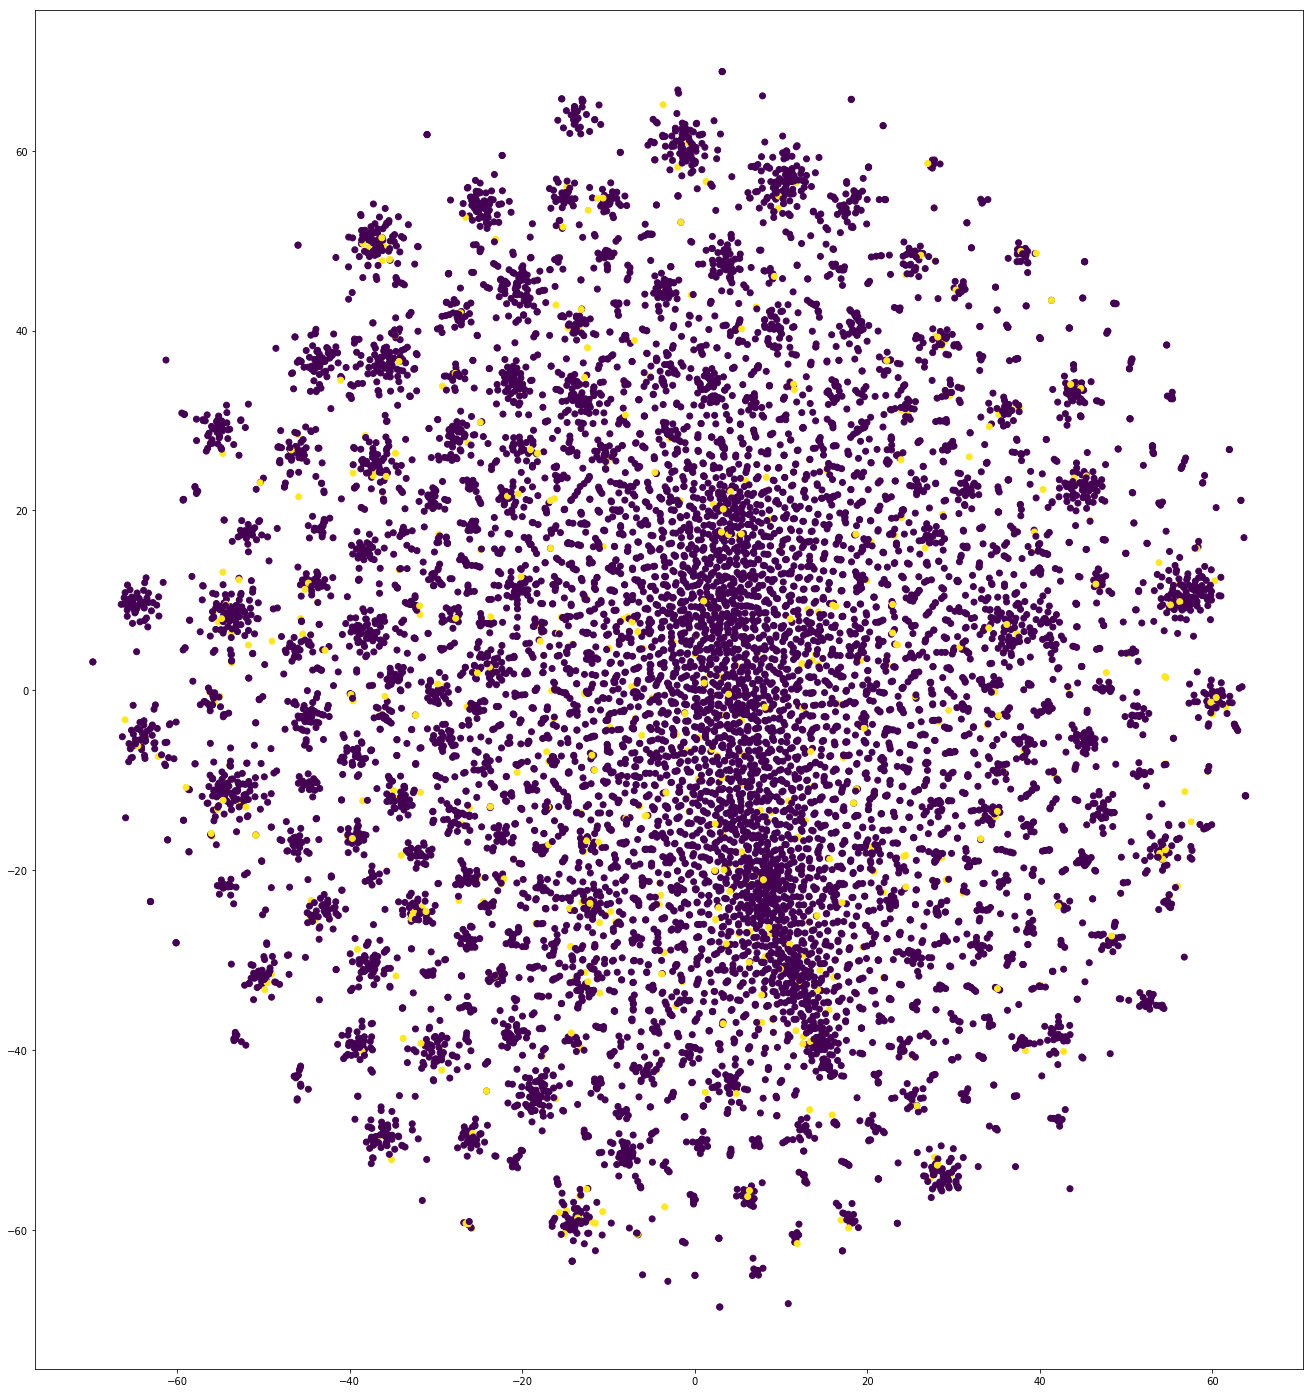

In [30]:
#######IGNORE: plot of submission titles#######
plt.figure(figsize=(50, 25))
plt.subplot(121)
y_all = [sub[9] for sub in sub_df]
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all)

In [59]:
scatter_sub= pd.DataFrame(X_tsne, columns = ['Dimension1', 'Dimension2'])
scatter_sub['y'] = y_all
scatter_sub['SubmissionTitle'] = [sub[6] for sub in sub_df]
scatter_sub.to_csv(r'submissions_plot_06032019.csv')